Tutorial 3 (ViT)
======================


## About

For this part of the assignment, you will gain some experience working with Visual Transformers (ViT).
The main activties will be around fine-tuning ViT model using HuggingFace Lib.

* **Fine-tuning ViT model**:

    Fine-tune the ViT model on the CIFAR-10, DTD, and COCO-O datasets.

Please note that from this notebook we will load all datasets in the same way.


<hr>

* The <b><font color="red">red</font></b> color indicates the task that should be done, like <b><font color="red">[TODO]</font></b>: ...
* Addicitional comments, hints are in <b><font color="blue">blue</font></b>. For example <b><font color="blue">[HINT]</font></b>: ...

## Prelimiaries

In [1]:
import os
import gdown
import zipfile

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms

from datasets import load_dataset
from datasets import Dataset, DatasetDict

from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

## Auxilary functions

In [3]:
def create_hf_cocoo_dataset(path_coco_o:str , path_data:str, seed:int =42, test_ratio=0.3):
    def load_image(example):
        example['image'] = Image.open(example['image_path'])
        return example

    if not os.path.exists(path_coco_o):
        url = 'https://drive.google.com/uc?id=1aBfIJN0zo_i80Hv4p7Ch7M8pRzO37qbq'
        zip_file_path = os.path.join(path_data, 'ood_coco.zip')
        gdown.download(url, zip_file_path, quiet=False)
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(path_data)

    cocoo_classes_list = os.listdir(path_coco_o)
    all_elements_coco = [
        (os.path.join(path_coco_o, label, 'val2017', img), index)
        for index, label in enumerate(cocoo_classes_list)
        for img in os.listdir(os.path.join(path_coco_o, label, 'val2017'))
    ]

    np.random.seed(seed)
    indices = np.arange(len(all_elements_coco))
    np.random.shuffle(indices)
    n_test = int(len(indices) * test_ratio)

    train_indices, test_indices = indices[n_test:], indices[:n_test]
    datasets = {}

    for split, split_indices in zip(['train', 'test'], [train_indices, test_indices]):
        split_data = [(all_elements_coco[i][0], all_elements_coco[i][1]) for i in split_indices]
        image_paths, labels = zip(*split_data)
        dataset = Dataset.from_dict({'image_path': image_paths, 'label': labels})
        datasets[split] = dataset.map(load_image, remove_columns=['image_path'])

    return DatasetDict(datasets), cocoo_classes_list

In [4]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

def processor_transform(processor):
    def curry(example_batch):
        inputs = processor([x for x in example_batch['img']], return_tensors='pt')
        inputs['labels'] = example_batch['label']
        return inputs
    return curry

## Load data

In [5]:
# Set the local folder with the data
path_data = "./data"
os.makedirs(path_data, exist_ok=True)

In [6]:
# Load cifar10 dataset
cifar10_dataset = load_dataset('cifar10', cache_dir=path_data)
cifar10_classes_list = cifar10_dataset['train'].features['label'].names

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
# Load DTD dataset
dtd_dataset = load_dataset("tanganke/dtd", cache_dir=path_data)
dtd_classes_list = dtd_dataset['train'].features['label'].names

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/450M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/179M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1880 [00:00<?, ? examples/s]

In [8]:
# Load COCO-O dataset
path_coco_o = os.path.join(path_data, 'ood_coco')
cocoo_dataset, cocoo_classes_list = create_hf_cocoo_dataset(path_coco_o, path_data)

Downloading...
From (original): https://drive.google.com/uc?id=1aBfIJN0zo_i80Hv4p7Ch7M8pRzO37qbq
From (redirected): https://drive.google.com/uc?id=1aBfIJN0zo_i80Hv4p7Ch7M8pRzO37qbq&confirm=t&uuid=8d8aef1d-9d5d-4f79-94e5-66059a7a0993
To: /content/data/ood_coco.zip
100%|██████████| 1.20G/1.20G [00:32<00:00, 37.0MB/s]


Map:   0%|          | 0/4748 [00:00<?, ? examples/s]

Map:   0%|          | 0/2034 [00:00<?, ? examples/s]

## Training

### cifar10

In [9]:
# We will use the 'base' version of the ViT family
model_name = "google/vit-base-patch16-224"

In [10]:
# Special object for preprocessing
processor = ViTImageProcessor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [11]:
# Set the transform to match what the processor expects
transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

In [12]:
# Load pretrain model
model = ViTForImageClassification.from_pretrained(model_name)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [13]:
# Inspect model
#print(model)
print(model.classifier)

Linear(in_features=768, out_features=1000, bias=True)


In [14]:
# Set the correct number of classes
# Note: ignore warning
num_classes = len(cifar10_classes_list)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


In [15]:
# Training arguments
args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False,
    report_to="none"
)

In [16]:
# We will take a small subset of the dataset to speed up things
# We are free to play with different number of (n_train, n_test)
n_train = 2000
n_test = 1000
train_subset = cifar10_dataset['train'].select(range(n_train))
test_subset = cifar10_dataset['test'].select(range(n_test))

# Prepare data for Trainer
transform_func = processor_transform(processor)
ds_train = train_subset.with_transform(transform_func)
ds_test = test_subset.with_transform(transform_func)

ds_test_full = cifar10_dataset['test'].with_transform(transform_func)

In [17]:
# Define HuggingFace 'Trainer'
trainer = Trainer(
    model,
    args,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=processor,
)

In [18]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.227273,0.802000
2,No log,0.706066,0.918000
3,No log,0.578925,0.935000


TrainOutput(global_step=96, training_loss=1.057209809621175, metrics={'train_runtime': 292.5069, 'train_samples_per_second': 20.512, 'train_steps_per_second': 0.328, 'total_flos': 4.64985275424768e+17, 'train_loss': 1.057209809621175, 'epoch': 3.0})

In [19]:
# Predict
outputs = trainer.predict(ds_test_full)
print(outputs.metrics)

{'test_loss': 0.586234450340271, 'test_accuracy': 0.935, 'test_runtime': 122.3706, 'test_samples_per_second': 81.719, 'test_steps_per_second': 1.283}


In [20]:
predictations = outputs.predictions.argmax(1)
true_labels = cifar10_dataset['test']['label']

In [21]:
# Detailed analysis (report)
print(classification_report(true_labels, predictations, target_names=cifar10_classes_list))

              precision    recall  f1-score   support

    airplane       0.96      0.94      0.95      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.92      0.88      0.90      1000
         cat       0.88      0.81      0.84      1000
        deer       0.93      0.95      0.94      1000
         dog       0.84      0.92      0.88      1000
        frog       0.98      0.97      0.97      1000
       horse       0.98      0.96      0.97      1000
        ship       0.95      0.99      0.97      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.94      0.93     10000



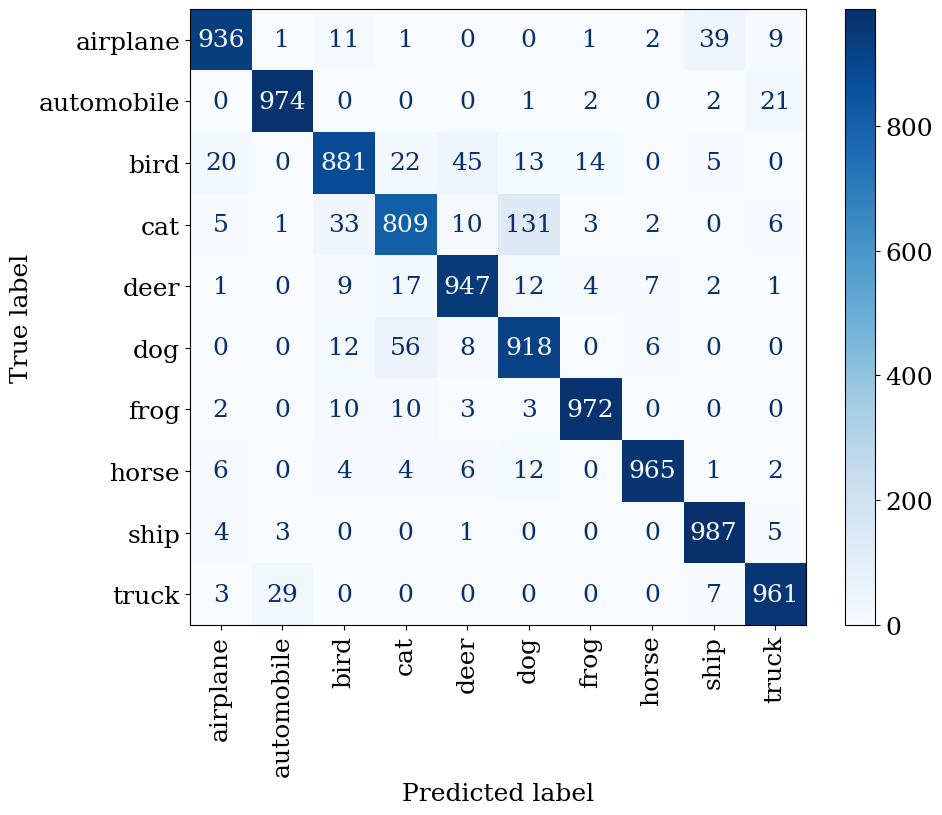

In [22]:
# Detailed analysis (confusion matrix)

cm = confusion_matrix(true_labels, predictations)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_classes_list)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90);

### Another dataset

<b><font color="red">[TODO]</font></b>: Conduct fine-tuning experiments for DTD dataset or COCO-O dataset or both. What is the accuracy, how does it compare to the cnn-based experiments?

In [23]:
print(f"COCO-O Dataset Info:")
print(f"Number of classes: {len(cocoo_classes_list)}")
print(f"Classes: {cocoo_classes_list}")
print(f"Train samples: {len(cocoo_dataset['train'])}")
print(f"Test samples: {len(cocoo_dataset['test'])}")

COCO-O Dataset Info:
Number of classes: 6
Classes: ['sketch', 'weather', 'handmake', 'tattoo', 'cartoon', 'painting']
Train samples: 4748
Test samples: 2034


In [24]:
num_classes_cocoo = len(cocoo_classes_list)
n_train_cocoo = 2000
n_test_cocoo = 1000

processor = ViTImageProcessor.from_pretrained(model_name)
model_cocoo = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes_cocoo,
    ignore_mismatched_sizes=True
)

def preprocess_batch(examples):
    images = [img.convert('RGB') if img.mode != 'RGB' else img for img in examples['image']]
    inputs = processor(images)
    return {
        'pixel_values': inputs['pixel_values'],
        'labels': examples['label']
    }

train_subset = cocoo_dataset['train'].select(range(n_train_cocoo))
test_subset = cocoo_dataset['test'].select(range(n_test_cocoo))

ds_train_cocoo = train_subset.map(preprocess_batch, batched=True, batch_size=100, remove_columns=['image'])
ds_test_cocoo = test_subset.map(preprocess_batch, batched=True, batch_size=100, remove_columns=['image'])

ds_train_cocoo.set_format(type='torch', columns=['pixel_values', 'labels'])
ds_test_cocoo.set_format(type='torch', columns=['pixel_values', 'labels'])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [25]:
args_cocoo = TrainingArguments(
    output_dir='./results_cocoo',
    logging_dir='./logs_cocoo',
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False,
    report_to="none",
    logging_steps=50,
)

In [26]:
trainer_cocoo = Trainer(
    model_cocoo,
    args_cocoo,
    train_dataset=ds_train_cocoo,
    eval_dataset=ds_test_cocoo,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=processor,
)

In [27]:
%%time
trainer_cocoo.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.805960,0.765000
2,1.039800,0.504791,0.888000
3,1.039800,0.445043,0.894000


CPU times: user 4min 57s, sys: 2.08 s, total: 4min 59s
Wall time: 9min 2s


TrainOutput(global_step=96, training_loss=0.7189553578694662, metrics={'train_runtime': 542.0093, 'train_samples_per_second': 11.07, 'train_steps_per_second': 0.177, 'total_flos': 4.6496860655616e+17, 'train_loss': 0.7189553578694662, 'epoch': 3.0})

In [28]:
outputs_cocoo = trainer_cocoo.predict(ds_test_cocoo)
print(outputs_cocoo.metrics)

predictions_cocoo = outputs_cocoo.predictions.argmax(1)
true_labels_cocoo = test_subset['label']

{'test_loss': 0.4450434446334839, 'test_accuracy': 0.894, 'test_runtime': 20.7579, 'test_samples_per_second': 48.174, 'test_steps_per_second': 0.771}


In [29]:
print(classification_report(true_labels_cocoo, predictions_cocoo, target_names=cocoo_classes_list))

              precision    recall  f1-score   support

      sketch       0.87      0.82      0.84       143
     weather       0.94      0.99      0.96       148
    handmake       0.89      0.82      0.86       137
      tattoo       0.98      1.00      0.99       131
     cartoon       0.86      0.91      0.88       297
    painting       0.86      0.81      0.84       144

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.90      1000
weighted avg       0.89      0.89      0.89      1000



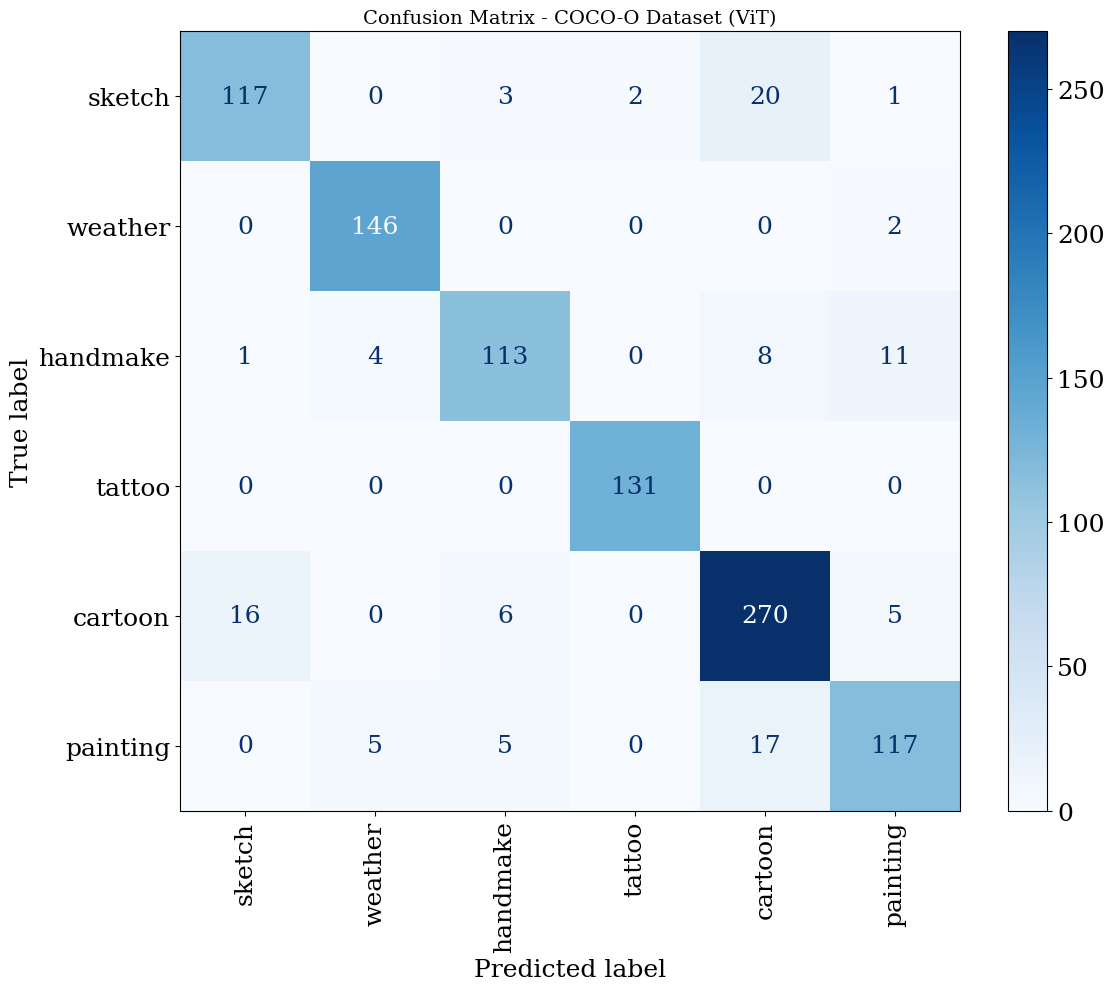

In [30]:
cm_cocoo = confusion_matrix(true_labels_cocoo, predictions_cocoo)
disp_cocoo = ConfusionMatrixDisplay(
    confusion_matrix=cm_cocoo,
    display_labels=cocoo_classes_list
)

fig, ax = plt.subplots(figsize=(12, 10))
disp_cocoo.plot(cmap='Blues', ax=ax, xticks_rotation=90, values_format='d')
plt.title('Confusion Matrix - COCO-O Dataset (ViT)', fontsize=14)
plt.tight_layout()
plt.show()

### Another ViT model

<b><font color="red">[TODO]</font></b>: Try other version of ViT model, like **ViT-Large** or other ViT based model, like [DeiT](https://huggingface.co/docs/transformers/en/model_doc/deit).

In [31]:
model_name = "google/vit-large-patch16-224"
num_classes_cocoo = len(cocoo_classes_list)
n_train_cocoo = 2000
n_test_cocoo = 1000

processor_large = ViTImageProcessor.from_pretrained(model_name)
model_cocoo_large = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes_cocoo,
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([6, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
ds_train_cocoo_large = train_subset.map(preprocess_batch, batched=True, batch_size=100, remove_columns=['image'])
ds_test_cocoo_large = test_subset.map(preprocess_batch, batched=True, batch_size=100, remove_columns=['image'])

ds_train_cocoo_large.set_format(type='torch', columns=['pixel_values', 'labels'])
ds_test_cocoo_large.set_format(type='torch', columns=['pixel_values', 'labels'])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [33]:
args_cocoo_large = TrainingArguments(
    output_dir='./results_cocoo_large',
    logging_dir='./logs_cocoo_large',
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False,
    report_to="none",
    logging_steps=50,
    fp16=True,  # Use mixed precision to save memory
)

In [34]:
trainer_cocoo_large = Trainer(
    model_cocoo_large,
    args_cocoo_large,
    train_dataset=ds_train_cocoo_large,
    eval_dataset=ds_test_cocoo_large,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=processor_large,
)

In [35]:
%%time
trainer_cocoo_large.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.605500,0.298284,0.897000
2,0.147200,0.232112,0.928000
3,0.054800,0.239674,0.931000


CPU times: user 4min 6s, sys: 32.9 s, total: 4min 39s
Wall time: 24min 51s


TrainOutput(global_step=189, training_loss=0.2206632863907587, metrics={'train_runtime': 1490.5013, 'train_samples_per_second': 4.025, 'train_steps_per_second': 0.127, 'total_flos': 1.643627297120256e+18, 'train_loss': 0.2206632863907587, 'epoch': 3.0})

In [36]:
eval_results_large = trainer_cocoo_large.evaluate()
print(f"\nViT-Large Test Accuracy: {eval_results_large['eval_accuracy']:.4f}")


ViT-Large Test Accuracy: 0.9310


In [37]:
outputs_cocoo_large = trainer_cocoo_large.predict(ds_test_cocoo_large)
predictions_cocoo_large = outputs_cocoo_large.predictions.argmax(1)
true_labels_cocoo_large = test_subset['label']

In [38]:
print(classification_report(true_labels_cocoo_large, predictions_cocoo_large, target_names=cocoo_classes_list))

              precision    recall  f1-score   support

      sketch       0.88      0.87      0.88       143
     weather       0.97      0.98      0.98       148
    handmake       0.91      0.95      0.93       137
      tattoo       1.00      1.00      1.00       131
     cartoon       0.93      0.89      0.91       297
    painting       0.91      0.95      0.93       144

    accuracy                           0.93      1000
   macro avg       0.93      0.94      0.94      1000
weighted avg       0.93      0.93      0.93      1000



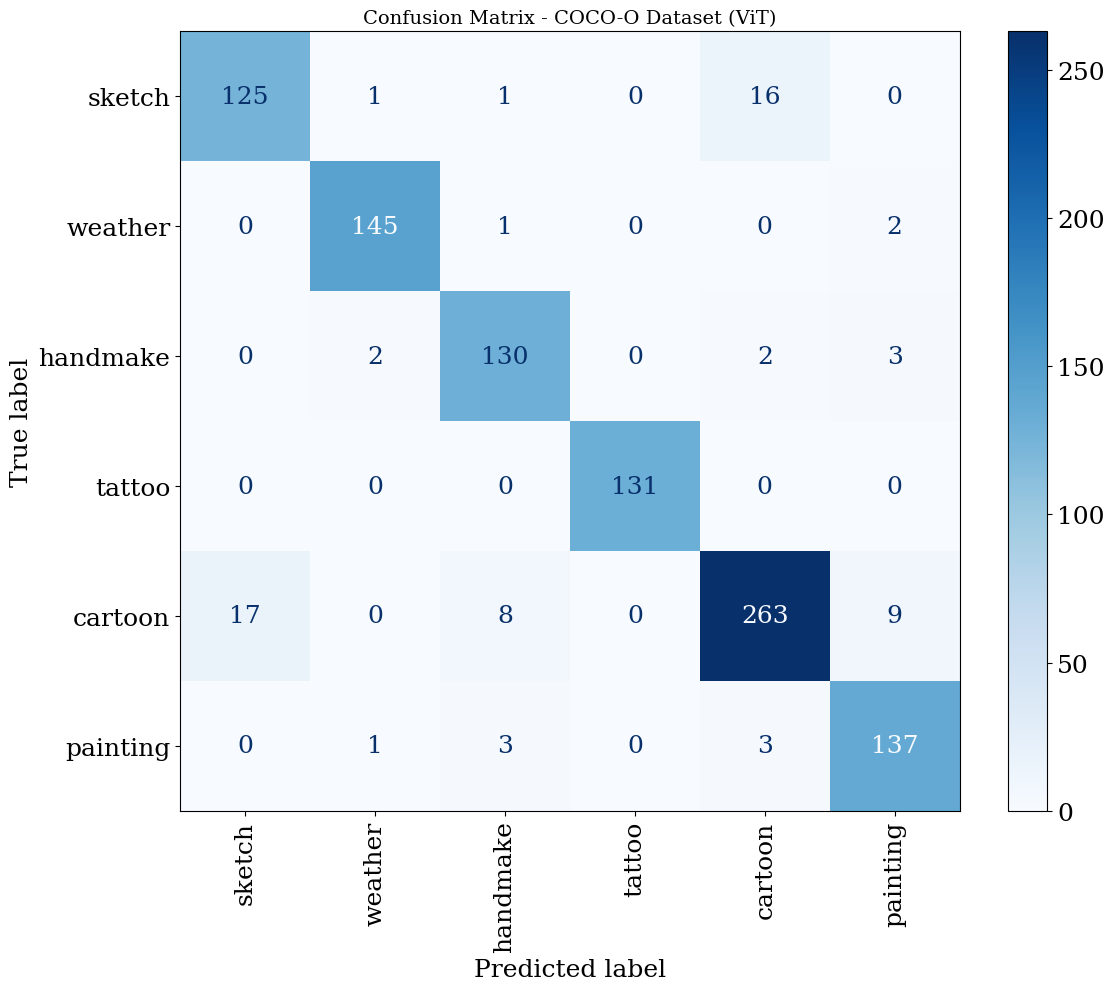

In [39]:
cm_cocoo = confusion_matrix(true_labels_cocoo_large, predictions_cocoo_large)
disp_cocoo = ConfusionMatrixDisplay(
    confusion_matrix=cm_cocoo,
    display_labels=cocoo_classes_list
)

fig, ax = plt.subplots(figsize=(12, 10))
disp_cocoo.plot(cmap='Blues', ax=ax, xticks_rotation=90, values_format='d')
plt.title('Confusion Matrix - COCO-O Dataset (ViT)', fontsize=14)
plt.tight_layout()
plt.show()